In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install -q diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 31.4 MB/s eta 0:00:00


In [ ]:

import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torch import nn
from torchvision import datasets, transforms
from torch.nn import functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import h5py
import numpy as np
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from PIL import Image
from tqdm.auto import tqdm, trange
from diffusers import DDPMScheduler, UNet2DModel
%load_ext tensorboard

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
with h5py.File('drive/MyDrive/Galaxy10_DECals.h5', 'r') as F:
    images_decals = np.array(F['images'])
    labels_decals = np.array(F['ans'])
with h5py.File('drive/MyDrive/Galaxy10.h5', 'r') as G:
    images_gals = np.array(G['images'])
    labels_gals = np.array(G['ans'])

In [ ]:
image_resolution = 64

In [ ]:
class Transforms():
    def __init__(self):
        self.resizer = torchvision.transforms.CenterCrop(size=(image_resolution*2.4, image_resolution*2.4))
        pass

    def resize(self, image, img_size):
        image = TF.resize(image,img_size)
        return image

    def __call__(self, image):
        image = Image.fromarray(image)
        image = TF.to_grayscale(image)
        image = self.resize(image, image_resolution)
        image = TF.to_tensor(image)
        return image

class GalaxyDataset(Dataset):
    def __init__(self, transform=None):
        self.images = []
        for image in images_decals:
          image = transform(image)
          self.images.append(image)

        self.labels = np.concatenate((np.zeros(len(labels_decals)), np.zeros(len(labels_gals))))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        return image, label

dataset = GalaxyDataset(Transforms())
batch_size = 512
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
ims = next(iter(train_loader))
print(np.min(ims[0].numpy()))
print(np.max(ims[0].numpy()))
print(ims[0].numpy().shape)

0.07450981
1.0
(512, 1, 64, 64)


34


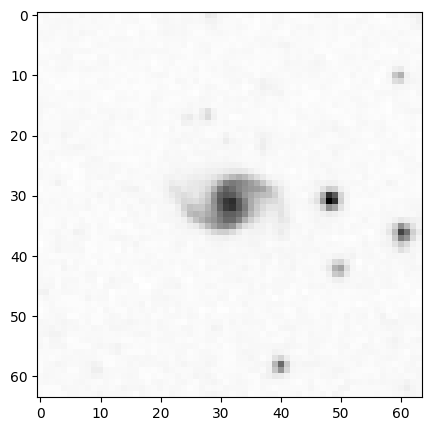

In [ ]:
im = ims[0][0]
im = torch.permute(im, (1, 2, 0))
plt.figure(figsize=(5, 5))
plt.imshow(im.numpy(), cmap='Greys')

print(len(train_loader))

In [ ]:
def corrupt(x, amount):
  noise = torch.randn_like(x)
  amount = amount.view(-1, 1, 1, 1)
  return x*(1-amount) + noise*amount
num_train_timesteps=1000
noise_scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps)

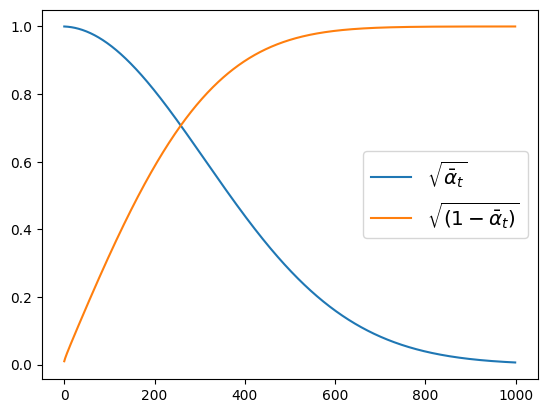

In [ ]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

Noisy X shape torch.Size([8, 1, 64, 64])


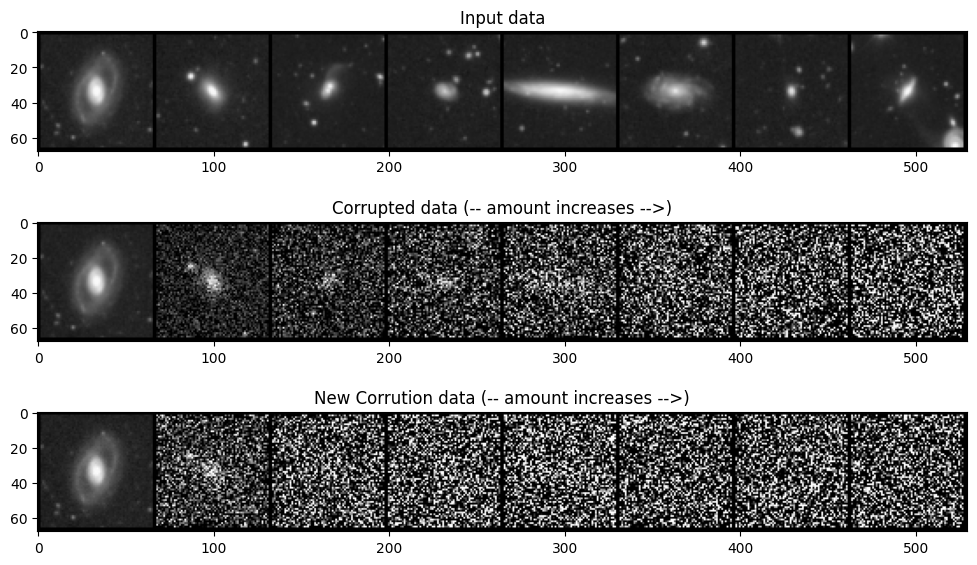

In [ ]:
ims = next(iter(train_loader))
ims = ims[0][:8]


# Plotting the input data
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torch.permute(torchvision.utils.make_grid(ims).clip(-1, 1),(1, 2, 0)))

# Adding noise
amount = torch.linspace(0, 1, ims.shape[0]) # Left to right -> more corruption
noised_x = corrupt(ims, amount)

# Add noise with scheduler
timesteps = torch.linspace(0, num_train_timesteps-1, 8).long().to(device)
noise = torch.randn_like(ims)


noisy_xb = noise_scheduler.add_noise(ims, noise, timesteps)
print('Noisy X shape', noisy_xb.shape)

# Plotting the noised version
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torch.permute(torchvision.utils.make_grid(noised_x).clip(-1, 1),(1, 2, 0)))

# Plotting the noised version
axs[2].set_title('New Corrution data (-- amount increases -->)')
axs[2].imshow(torch.permute(torchvision.utils.make_grid(noisy_xb).clip(-1, 1),(1, 2, 0)))

In [ ]:
# Measure GPU memory before
initial_memory = torch.cuda.memory_allocated()

# Dereference
model = None
optimizer = None
data_batch_dev = None
pred = None
timesteps = None
data_batch = None
data_batch_dev = None

# Garbage collect
import gc
torch.cuda.empty_cache()
gc.collect()

#Nuclear option to clear
!nvidia-smi --gpu-reset -i 0

# Measure GPU memory after
final_memory = torch.cuda.memory_allocated()

# Calculate the memory reduction
memory_reduced = initial_memory - final_memory

print(f"Before memory : {initial_memory / (1024**3):.1f} GB")
print(f"Current memory : {final_memory / (1024**3):.1f} GB")
print(f"Memory reduced: {memory_reduced / (1024**3)} GB")

GPU 00000000:00:04.0 is currently in use by another process.

1 device is currently being used by one or more other processes (e.g., Fabric Manager, CUDA application, graphics application such as an X server, or a monitoring application such as another instance of nvidia-smi). Please first kill all processes using this device and all compute applications running in the system.
Before memory : 0.0 GB
Current memory : 0.0 GB
Memory reduced: 4.76837158203125e-07 GB


In [ ]:
class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=10, class_emb_size=4):
    super().__init__()

    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=image_resolution,           # the target image resolution
        in_channels=1 + class_emb_size, # Additional input channels for class cond.
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    # Shape of x:
    bs, ch, w, h = x.shape

    # class conditioning in right shape to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dinemsion
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # Feed this to the unet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 1, 28, 28)

In [ ]:
model = ClassConditionedUnet().to(device)
writer = SummaryWriter()

In [ ]:

def train(model, train_loader, optimizer, criterion, train_losses):
    model.train()
    for num, data_batch in enumerate(tqdm(train_loader)):

        current_memory = torch.cuda.memory_allocated()

        timesteps = torch.randint(
            0,
            num_train_timesteps-1,
            (batch_size,),
            device=device,
        ).long()

        data_batch_dev = data_batch[0].to(device) * 2. - 1.
        y = data_batch[1].to(device)

        y = y.to(torch.long)

        initial_memory = torch.cuda.memory_allocated()

        noise = torch.randn_like(data_batch_dev)
        noisy_x = noise_scheduler.add_noise(data_batch_dev, noise, timesteps).to(device)


        initial_memory = torch.cuda.memory_allocated()
        pred = model(noisy_x, timesteps,y)
        loss_train = criterion(pred, noise)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        number_step = num + epoch*len(train_loader)
        train_losses.append(loss_train.item()/batch_size)
        writer.add_scalar('Loss/train', loss_train.item()/batch_size, number_step)
        writer.add_scalar('Loss/memory', current_memory, number_step)


        # Measure GPU memory after
        final_memory = torch.cuda.memory_allocated()
        # Calculate the memory reduction
        memory_added_back = - initial_memory + final_memory


In [ ]:
learning_rate = 1e-4
epochs = 20
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train_losses = []
writer.add_hparams({'lr': learning_rate, 'bsize': batch_size, 'epochs': epochs}, {})

for epoch in range(epochs):
    train(model, train_loader, optimizer, criterion, train_losses)

writer.close()

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

In [ ]:
def unnormalize(images, mean=1.0, std=2.):
    if not torch.is_tensor(images):
        raise TypeError("Input images should be a torch.Tensor.")

    if not isinstance(mean, (float, int)) or not isinstance(std, (float, int)):
        raise TypeError("Mean and std should be floats or ints.")

    images = (images + mean) / std

    return images

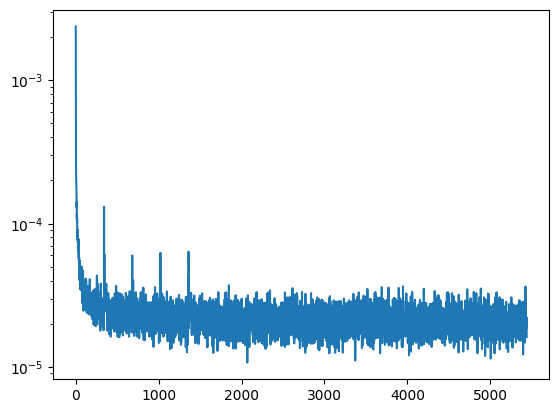

In [ ]:
plt.semilogy(train_losses)

torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 1, 1])


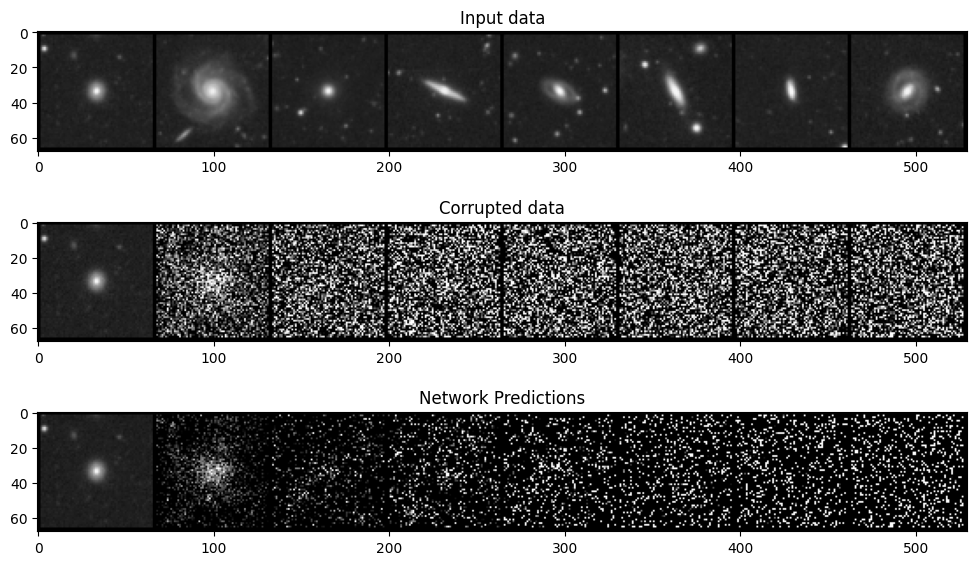

In [ ]:
# Fetch some data
dat = next(iter(train_loader))
x = dat[0][:8].to(device) # Only using the first 8 for easy plotting
y = dat[1][:8].to(device).to(torch.long)

# Create noise schedule
sqrt_alpha_prod = noise_scheduler.alphas_cumprod.cpu() ** 0.5
sqrt_one_minus_alpha_prod = (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5
sqrt_alpha_prod.to(device)
sqrt_one_minus_alpha_prod.to(device)

timesteps = torch.linspace(0, num_train_timesteps-1, 8).long().to(device)
noise = torch.randn_like(x).to(device) # << NB: randn not rand
noisy_x = noise_scheduler.add_noise(x, noise, timesteps).to(device)

# Get the model predictions
with torch.no_grad():
  preds = model(noisy_x, timesteps,y)
  preds = preds.detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torch.permute(torchvision.utils.make_grid(x.detach().cpu()),(1, 2, 0)))

axs[1].set_title('Corrupted data')
axs[1].imshow(torch.permute(torchvision.utils.make_grid(noisy_x.detach().cpu()),(1, 2, 0)))

axs[2].set_title('Network Predictions')
noise_cpu = noisy_x.detach().cpu()
timesteps = timesteps.cpu().view(-1, 1, 1, 1)
original_samples = (noise_cpu - sqrt_one_minus_alpha_prod[timesteps] * unnormalize(preds))/sqrt_alpha_prod[timesteps]
axs[2].imshow(torch.permute(torchvision.utils.make_grid(original_samples),(1, 2, 0)))

0it [00:00, ?it/s]

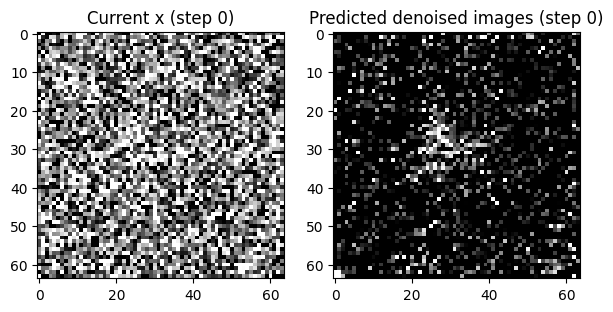

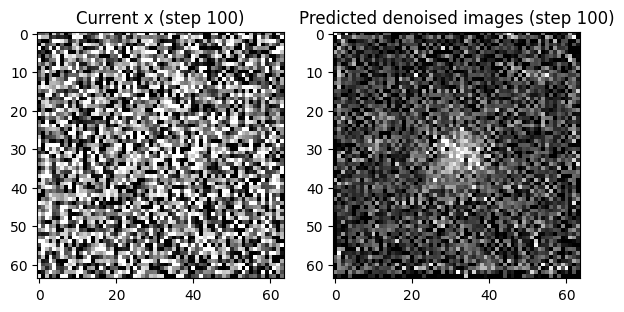

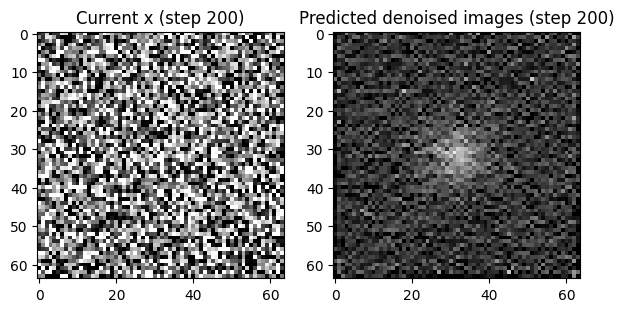

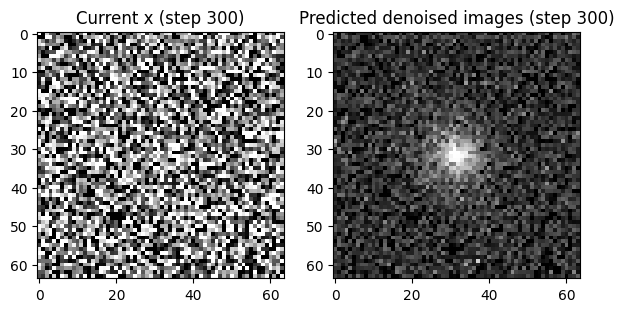

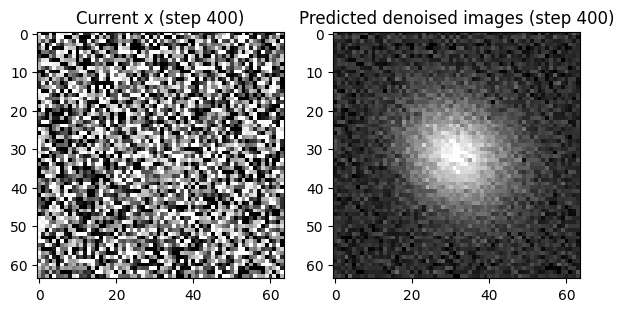

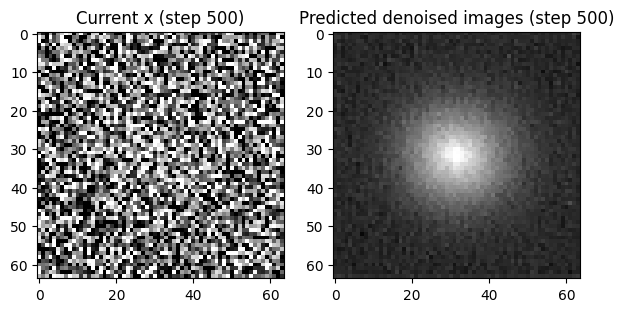

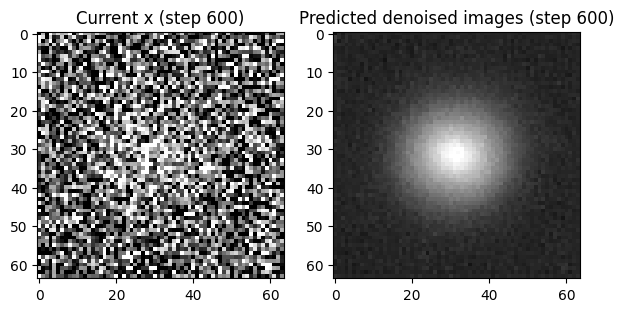

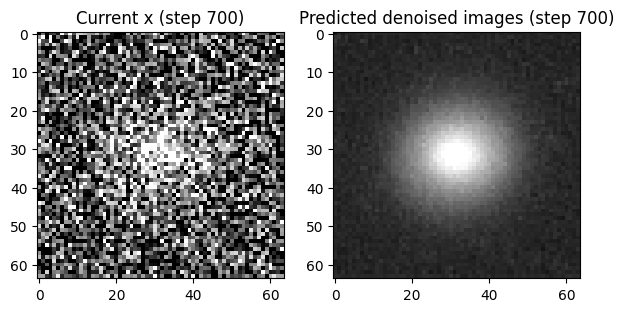

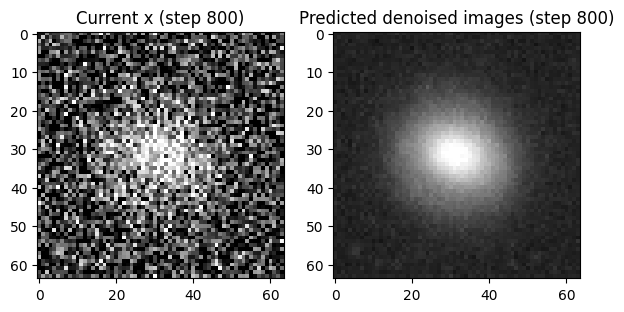

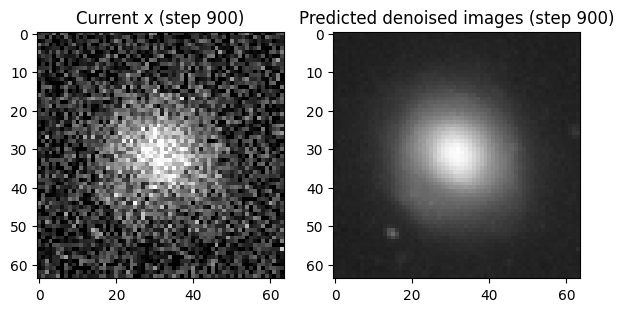

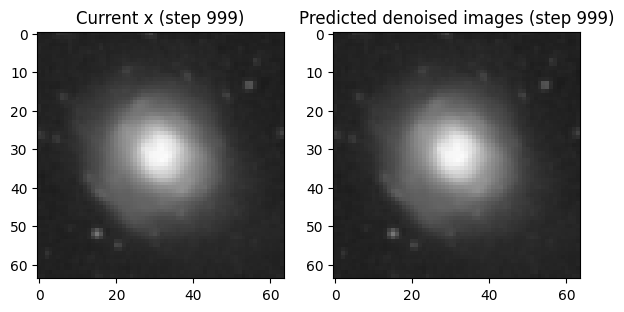

In [ ]:
x = torch.randn(1, 1, image_resolution, image_resolution).to(device) # Start from random
y = torch.tensor(7).to(device).to(torch.long)
y = torch.zeros_like(y)
writeout_frequency = 100

# Loop through the sampling timesteps
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
  model_input = noise_scheduler.scale_model_input(x, t)

  # Get the prediction
  with torch.no_grad():
    noise_pred = model(model_input, t,y.unsqueeze(0))
  scheduler_output = noise_scheduler.step(noise_pred, t, x)
  x = scheduler_output.prev_sample
  # Occasionally display both x and the predicted denoised images
  if i % writeout_frequency == 0 or i == len(noise_scheduler.timesteps) - 1:
    fig, axs = plt.subplots(1, 2, figsize=(7, 4))

    grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
    axs[0].imshow(unnormalize(grid.cpu()).clip(-1, 1) )
    axs[0].set_title(f"Current x (step {i})")

    pred_x0 = (
        scheduler_output.pred_original_sample
    )  # Not available for all schedulers
    grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
    axs[1].imshow(unnormalize(grid.cpu()).clip(-1, 1) )
    axs[1].set_title(f"Predicted denoised images (step {i})")
    plt.show()


0it [00:00, ?it/s]

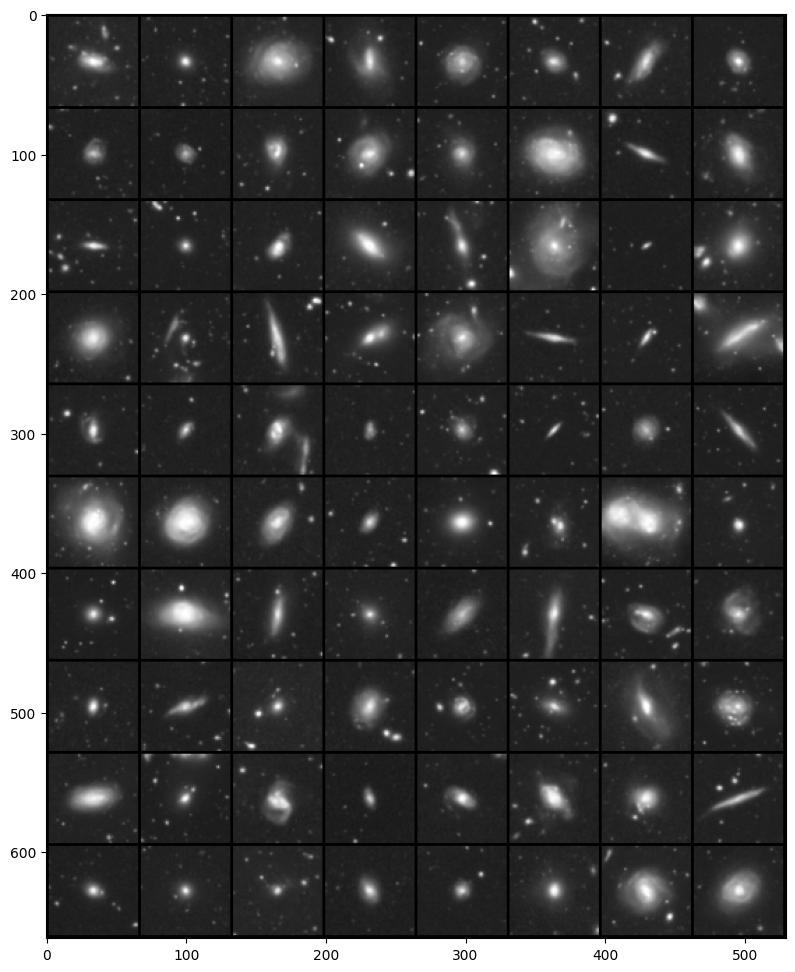

In [ ]:
x = torch.randn(80, 1, image_resolution, image_resolution).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)
y = torch.zeros_like(y)

for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = model(x, t, y)  # Again, note that we pass in our labels y

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torch.permute(torchvision.utils.make_grid(unnormalize(x.detach().cpu())),(1, 2, 0)))